# <font color='blue'>Segmentação de Clientes de Food Delivery</font>

### Carregando os Pacotes

In [1]:
# Imports

# Manipulação e visualização de dados
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

### Carregando e Compreendendo os Dados

In [2]:
# Carrega o dataset
df_food_delivery = pd.read_csv("dados/dataset.csv", encoding = 'utf-8')

In [3]:
# Shape
df_food_delivery.shape

(260645, 7)

In [4]:
# Visualiza os dados
df_food_delivery.head()

id_transacao       horario_pedido  localidade  nome_item  quantidade_item  \
0     0x7901ee  2019-01-16 18:33:00           7     bebida                2   
1     0x7901ee  2019-01-16 18:33:00           7      pizza                2   
2     0x7901ee  2019-01-16 18:33:00           7  sobremesa                2   
3     0x12b47f  2019-09-04 12:36:00           3     salada                1   
4     0x12b47f  2019-09-04 12:36:00           3  sobremesa                1   

    latitude  longitude  
0  41.794132 -88.010140  
1  41.794132 -88.010140  
2  41.794132 -88.010140  
3  41.884490 -87.627059  
4  41.884490 -87.627059

## Dicionário de Dados

        Variável = Descrição
        
        id_transacaoID da transação = Um mesmo ID pode ter vários itens de um pedido.
        horario_pedido = Horário exato do pedido.
        localidade = Localidade que processou o pedido (unidade do restaurante).
        nome_item = Nome do item (pizza, salada, bebida e sobremesa).
        quantidade_item = Quantidade de itens no pedido.
        latitude = Latitude da localidadeonde o pedido foi gerado.
        longitude = Longitude da localidadeonde o pedido foi gerado.

### Análise Exploratória



In [6]:
# Verifica o total de valores únicos por coluna
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [7]:
# Tipos de dados
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [8]:
# Resumo das colunas numéricas
df_food_delivery['quantidade_item'].describe()

count    260645.000000
mean          2.447010
std           1.330863
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: quantidade_item, dtype: float64

In [9]:
# Lista para receber o total de pedidos
total_pedidos = []

In [10]:
%%time

print("\nIniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...")

# Extraímos cada id e cada grupo do 'group by' por id_transacao
for k, group in df_food_delivery.groupby('id_transacao'):
    
    # Extraímos cada id e cada grupo do group by por horario_pedido
    for m, n in group.groupby('horario_pedido'):
        
        # Extraímos cada item de cada grupo
        id_transacao = k
        horario_pedido = m
        localidade = n['localidade'].values.tolist()[0]
        bebida = 0
        pizza = 0
        sobremesa = 0
        salada = 0
        n = n.reset_index(drop = True)
        
        # E então contabilizamos os itens pedidos
        for i in range(len(n)):
            item = n.loc[i, 'nome_item']
            num = n.loc[i, 'quantidade_item']
            
            if item == 'bebida':
                bebida = bebida + num
            
            elif item == 'pizza':
                pizza = pizza + num
            
            elif item == 'sobremesa':
                sobremesa = sobremesa + num
            
            elif item == 'salada':
                salada = salada + num
        
        output = [id_transacao, horario_pedido, localidade, bebida, pizza, sobremesa, salada]
        total_pedidos.append(output)
        
print("\nAgrupamento concluído!")


Iniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...

Agrupamento concluído!
Wall time: 3min 17s


In [11]:
# Convertemos a lista para dataframe
df_item_pedidos = pd.DataFrame(total_pedidos)

In [12]:
# Ajustamos os nomes das colunas
df_item_pedidos.columns = ['id_transacao', 'horario_pedido', 'localidade', 'bebida', 'pizza', 'sobremesa', 'salada']

In [13]:
# Shape
df_item_pedidos.shape

(100000, 7)

In [14]:
# Verifica o total de valores únicos por coluna
df_item_pedidos.nunique()

id_transacao      100000
horario_pedido     76799
localidade             9
bebida                 6
pizza                  6
sobremesa              5
salada                 6
dtype: int64

In [15]:
# Visualiza o resultado do pivot
df_item_pedidos.head(10)

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0     0x10000a  2019-01-29 00:48:00           9       0      1          1   
1     0x100058  2019-05-05 00:08:00           6       0      2          2   
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5   
3     0x10014c  2019-02-23 00:15:00           6       0      1          1   
4     0x1001d8  2019-06-30 17:50:00           2       3      3          3   
5     0x1002af  2019-12-28 17:25:00           9       3      3          4   
6     0x10034c  2019-03-12 18:17:00           5       3      4          4   
7     0x100378  2019-10-13 18:44:00           4       4      4          5   
8     0x100391  2019-10-10 18:07:00           5       4      4          4   
9     0x1003a9  2019-06-23 00:39:00           6       0      2          2   

   salada  
0       0  
1       0  
2       1  
3       0  
4       0  
5       1  
6       0  
7       1  
8       0  
9       0

### Extraindo Granularidade de Tempo

A coluna de horário do pedido tem detalhes como mês, dia e ano. Em algum momento pode ser interessante fazer a segmentação por mês, por exemplo. Vamos então extrair o mês e colocar em uma coluna separada.

In [16]:
# Extraímos o mês da coluna horario_pedido e gravamos em uma nova coluna
df_item_pedidos['mes'] = df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x,"%Y-%m-%d %H:%M:%S")))


In [17]:
# Visualiza o resultado
df_item_pedidos.head(10)

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0     0x10000a  2019-01-29 00:48:00           9       0      1          1   
1     0x100058  2019-05-05 00:08:00           6       0      2          2   
2     0x1000c8  2019-01-28 19:24:00           9       4      4          5   
3     0x10014c  2019-02-23 00:15:00           6       0      1          1   
4     0x1001d8  2019-06-30 17:50:00           2       3      3          3   
5     0x1002af  2019-12-28 17:25:00           9       3      3          4   
6     0x10034c  2019-03-12 18:17:00           5       3      4          4   
7     0x100378  2019-10-13 18:44:00           4       4      4          5   
8     0x100391  2019-10-10 18:07:00           5       4      4          4   
9     0x1003a9  2019-06-23 00:39:00           6       0      2          2   

   salada mes  
0       0  01  
1       0  05  
2       1  01  
3       0  02  
4       0  06  
5       1  12  
6       0  03  
7       1  10  
8       0  10  
9       0  06

### Ajuste de Índices

Para segmentar os pedidos dos clientes, precisamos de uma coluna de identificação de cada registro. Não podemos usar id_transacao, pois essa coluna representa um dado válido e além disso não é um valor único, logo não pode ser usado como índice.

Vamos então criar uma coluna usando o índice atual, o que acha? Vamos checar o índice:

In [18]:
# Dataset
df_item_pedidos

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0         0x10000a  2019-01-29 00:48:00           9       0      1          1   
1         0x100058  2019-05-05 00:08:00           6       0      2          2   
2         0x1000c8  2019-01-28 19:24:00           9       4      4          5   
3         0x10014c  2019-02-23 00:15:00           6       0      1          1   
4         0x1001d8  2019-06-30 17:50:00           2       3      3          3   
5         0x1002af  2019-12-28 17:25:00           9       3      3          4   
6         0x10034c  2019-03-12 18:17:00           5       3      4          4   
7         0x100378  2019-10-13 18:44:00           4       4      4          5   
8         0x100391  2019-10-10 18:07:00           5       4      4          4   
9         0x1003a9  2019-06-23 00:39:00           6       0      2          2   
10        0x100402  2019-02-16 12:18:00           4       0      0          1   
11        0x100464  2019-07-11 11:02:00           8       0      1          3   
12        0x100471  2019-06-23 00:39:00           2       0      1          1   
13        0x100526  2019-03-25 00:42:00           2       0      1          1   
14        0x100596  2019-02-15 19:45:00           4       3      3          3   
15        0x10067d  2019-02-07 00:12:00           6       0      2          2   
16        0x10068b  2019-01-18 12:21:00           9       0      0          2   
17        0x1006b4  2019-09-18 00:37:00           6       0      1          1   
18        0x1006ef  2019-07-23 00:17:00           6       0      1          1   
19        0x100709  2019-02-18 01:05:00           6       1      2          2   
20        0x10070c  2019-03-27 18:44:00           7       3      3          3   
21        0x100712  2019-02-01 13:58:00           2       0      0          5   
22        0x10075e  2019-04-21 19:12:00           7       5      5          5   
23        0x100773  2019-02-28 19:40:00           6       5      5          5   
24        0x10085a  2019-04-10 13:13:00           4       0      1          1   
25        0x100897  2019-09-02 12:41:00           9       0      1          2   
26        0x1008c6  2019-05-09 00:17:00           1       0      1          1   
27        0x1008d6  2019-01-26 13:29:00           3       0      0          2   
28        0x1008f1  2019-05-30 19:47:00           7       2      2          3   
29        0x10092f  2019-12-11 00:03:00           1       0      1          1   
...            ...                  ...         ...     ...    ...        ...   
99970      0xff786  2019-09-29 23:24:00           6       0      1          1   
99971      0xff7b0  2019-03-29 19:24:00           3       1      1          1   
99972      0xff7c7  2019-03-24 18:45:00           6       5      5          5   
99973      0xff7da  2019-05-08 00:21:00           6       0      1          1   
99974      0xff8ad  2019-12-22 14:30:00           1       0      0          3   
99975      0xff8e9  2019-09-02 12:11:00           8       0      0          2   
99976      0xff952  2019-03-04 17:21:00           4       1      1          1   
99977      0xff9d0  2019-02-02 00:21:00           6       0      3          3   
99978      0xff9e9  2019-12-03 16:20:00           4       3      3          4   
99979      0xffa04  2019-05-24 23:56:00           2       0      2          2   
99980      0xffae8  2019-05-02 01:09:00           2       0      1          1   
99981      0xffb2f  2019-04-21 17:29:00           4       3      3          3   
99982      0xffb47  2019-11-24 12:52:00           8       0      0          3   
99983      0xffb7a  2019-12-23 17:37:00           8       4      4          4   
99984      0xffb95  2019-12-17 12:47:00           3       0      1          1   
99985      0xffb9d  2019-07-07 17:03:00           7       3      3          4   
99986      0xffbec  2019-02-28 18:46:00           7       4      4          4   
99987      0xffc36  2019-04-23 00:42:

In [19]:
# Índice
df_item_pedidos.index

RangeIndex(start=0, stop=100000, step=1)

In [20]:
# Fazemos o reset no índice e gravamos o resultado em outro dataframe
df_item_pedidos_idx = df_item_pedidos.reset_index()

In [21]:
# Pronto, agora temos uma coluna de ID com valor único para cada registro
df_item_pedidos_idx.head()

index id_transacao       horario_pedido  localidade  bebida  pizza  \
0      0     0x10000a  2019-01-29 00:48:00           9       0      1   
1      1     0x100058  2019-05-05 00:08:00           6       0      2   
2      2     0x1000c8  2019-01-28 19:24:00           9       4      4   
3      3     0x10014c  2019-02-23 00:15:00           6       0      1   
4      4     0x1001d8  2019-06-30 17:50:00           2       3      3   

   sobremesa  salada mes  
0          1       0  01  
1          2       0  05  
2          5       1  01  
3          1       0  02  
4          3       0  06

In [22]:
# Dataset
df_item_pedidos

id_transacao       horario_pedido  localidade  bebida  pizza  sobremesa  \
0         0x10000a  2019-01-29 00:48:00           9       0      1          1   
1         0x100058  2019-05-05 00:08:00           6       0      2          2   
2         0x1000c8  2019-01-28 19:24:00           9       4      4          5   
3         0x10014c  2019-02-23 00:15:00           6       0      1          1   
4         0x1001d8  2019-06-30 17:50:00           2       3      3          3   
5         0x1002af  2019-12-28 17:25:00           9       3      3          4   
6         0x10034c  2019-03-12 18:17:00           5       3      4          4   
7         0x100378  2019-10-13 18:44:00           4       4      4          5   
8         0x100391  2019-10-10 18:07:00           5       4      4          4   
9         0x1003a9  2019-06-23 00:39:00           6       0      2          2   
10        0x100402  2019-02-16 12:18:00           4       0      0          1   
11        0x100464  2019-07-11 11:02:00           8       0      1          3   
12        0x100471  2019-06-23 00:39:00           2       0      1          1   
13        0x100526  2019-03-25 00:42:00           2       0      1          1   
14        0x100596  2019-02-15 19:45:00           4       3      3          3   
15        0x10067d  2019-02-07 00:12:00           6       0      2          2   
16        0x10068b  2019-01-18 12:21:00           9       0      0          2   
17        0x1006b4  2019-09-18 00:37:00           6       0      1          1   
18        0x1006ef  2019-07-23 00:17:00           6       0      1          1   
19        0x100709  2019-02-18 01:05:00           6       1      2          2   
20        0x10070c  2019-03-27 18:44:00           7       3      3          3   
21        0x100712  2019-02-01 13:58:00           2       0      0          5   
22        0x10075e  2019-04-21 19:12:00           7       5      5          5   
23        0x100773  2019-02-28 19:40:00           6       5      5          5   
24        0x10085a  2019-04-10 13:13:00           4       0      1          1   
25        0x100897  2019-09-02 12:41:00           9       0      1          2   
26        0x1008c6  2019-05-09 00:17:00           1       0      1          1   
27        0x1008d6  2019-01-26 13:29:00           3       0      0          2   
28        0x1008f1  2019-05-30 19:47:00           7       2      2          3   
29        0x10092f  2019-12-11 00:03:00           1       0      1          1   
...            ...                  ...         ...     ...    ...        ...   
99970      0xff786  2019-09-29 23:24:00           6       0      1          1   
99971      0xff7b0  2019-03-29 19:24:00           3       1      1          1   
99972      0xff7c7  2019-03-24 18:45:00           6       5      5          5   
99973      0xff7da  2019-05-08 00:21:00           6       0      1          1   
99974      0xff8ad  2019-12-22 14:30:00           1       0      0          3   
99975      0xff8e9  2019-09-02 12:11:00           8       0      0          2   
99976      0xff952  2019-03-04 17:21:00           4       1      1          1   
99977      0xff9d0  2019-02-02 00:21:00           6       0      3          3   
99978      0xff9e9  2019-12-03 16:20:00           4       3      3          4   
99979      0xffa04  2019-05-24 23:56:00           2       0      2          2   
99980      0xffae8  2019-05-02 01:09:00           2       0      1          1   
99981      0xffb2f  2019-04-21 17:29:00           4       3      3          3   
99982      0xffb47  2019-11-24 12:52:00           8       0      0          3   
99983      0xffb7a  2019-12-23 17:37:00           8       4      4          4   
99984      0xffb95  2019-12-17 12:47:00           3       0      1          1   
99985      0xffb9d  2019-07-07 17:03:00           7       3      3          4   
99986      0xffbec  2019-02-28 18:46:00           7       4      4          4   
99987      0xffc36  2019-04-23 00:42:

### Análise Descritiva

### Distplot dos Atributos Usados Para Segmentação

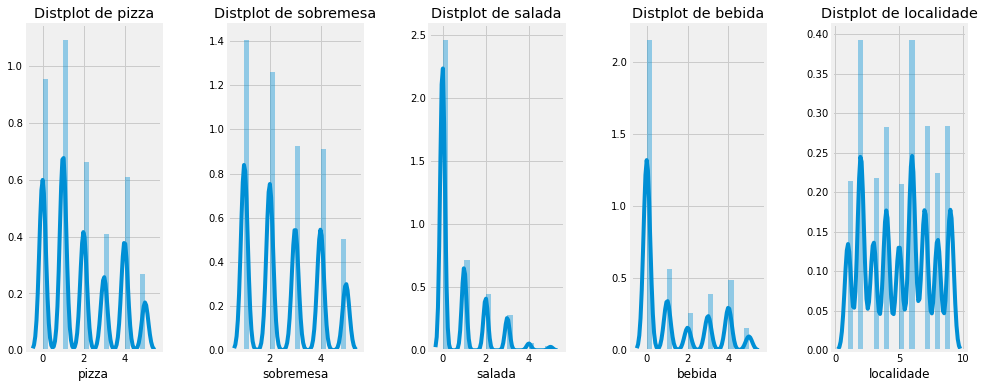

In [23]:
# Plot

# Tamanho da figura
plt.figure(1 , figsize = (15 , 6))

# Inicializa o contador
n = 0 

# Loop pelas colunas
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df_item_pedidos[x] , bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()

### Gráfico de Total de Pedidos Por Localidade

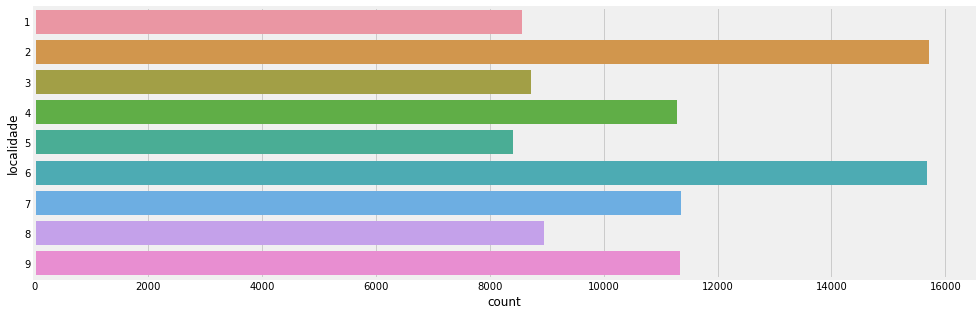

In [24]:
# Plot
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'localidade' , data = df_item_pedidos)
plt.show()

### Regplot dos Atributos Usados Para Segmentação

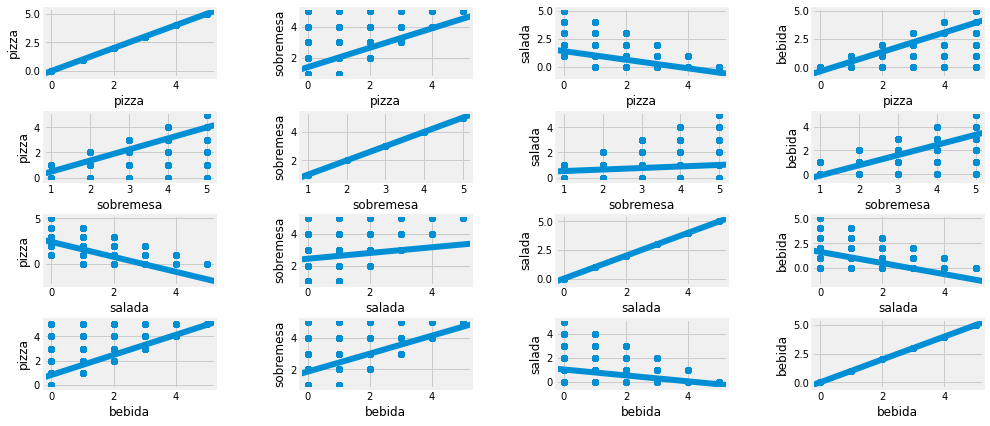

In [25]:
# Relação Entre os Atributos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 7))

# Inicializa o contador
n = 0 

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
        n += 1
        plt.subplot(4 , 4 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df_item_pedidos)
        plt.ylabel(y)
plt.show()

### Definindo as Variáveis Para Segmentação

Vamos remover id_transacao, horario_pedido, localidade e mes para nossas primeiras atividades de clusterização.

In [26]:
# Filtrando o dataframe por colunas 
df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

index  bebida  pizza  sobremesa  salada
0          0       0      1          1       0
1          1       0      2          2       0
2          2       4      4          5       1
3          3       0      1          1       0
4          4       3      3          3       0
5          5       3      3          4       1
6          6       3      4          4       0
7          7       4      4          5       1
8          8       4      4          4       0
9          9       0      2          2       0
10        10       0      0          1       1
11        11       0      1          3       2
12        12       0      1          1       0
13        13       0      1          1       0
14        14       3      3          3       0
15        15       0      2          2       0
16        16       0      0          2       2
17        17       0      1          1       0
18        18       0      1          1       0
19        19       1      2          2       0
20        20       3      3          3       0
21        21       0      0          5       5
22        22       5      5          5       0
23        23       5      5          5       0
24        24       0      1          1       0
25        25       0      1          2       1
26        26       0      1          1       0
27        27       0      0          2       2
28        28       2      2          3       1
29        29       0      1          1       0
...      ...     ...    ...        ...     ...
99970  99970       0      1          1       0
99971  99971       1      1          1       0
99972  99972       5      5          5       0
99973  99973       0      1          1       0
99974  99974       0      0          3       3
99975  99975       0      0          2       2
99976  99976       1      1          1       0
99977  99977       0      3          3       0
99978  99978       3      3          4       1
99979  99979       0      2          2       0
99980  99980       0      1          1       0
99981  99981       3      3          3       0
99982  99982       0      0          3       3
99983  99983       4      4          4       0
99984  99984       0      1          1       0
99985  99985       3      3          4       1
99986  99986       4      4          4       0
99987  99987       0      1          1       0
99988  99988       0      0          1       1
99989  99989       3      3          3       0
99990  99990       1      1          2       1
99991  99991       5      5          5       0
99992  99992       0      2          2       0
99993  99993       0      0          1       1
99994  99994       1      1          2       1
99995  99995       4      4          4       0
99996  99996       0      1          1       0
99997  99997       1      1          1       0
99998  99998       0      2          2       0
99999  99999       0      1          1       0

[100000 rows x 5 columns]

In [27]:
# Vamos gerar um novo dataframe com o slice anterior
df = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

In [28]:
# Dataset
df.head()

index  bebida  pizza  sobremesa  salada
0      0       0      1          1       0
1      1       0      2          2       0
2      2       4      4          5       1
3      3       0      1          1       0
4      4       3      3          3       0

### Segmentação 1

Vamos realizar nossa primeira segmentação usando 2 variáveis.

#### Segmentação 1 - Definindo o Número de Atributos


Usando 2 Variáveis (Pizza e Sobremesa).

In [29]:
# Usaremos duas variáveis
X1 = df[['pizza' , 'sobremesa']].iloc[: , :].values

In [30]:
# Lista do WCSS
wcss_X1 = []

#### Segmentação 1 - Encontrando o Valor Ideal de Clusters

Vamos testar diferentes valores de K (valores de cluster) entre 2 e 10.

Para a inicialização dos clusters, usamos o algoritmo k-means++ que oferece convergência mais rápida para o resultado final.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [31]:
# Loop para testar os valores de K
for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

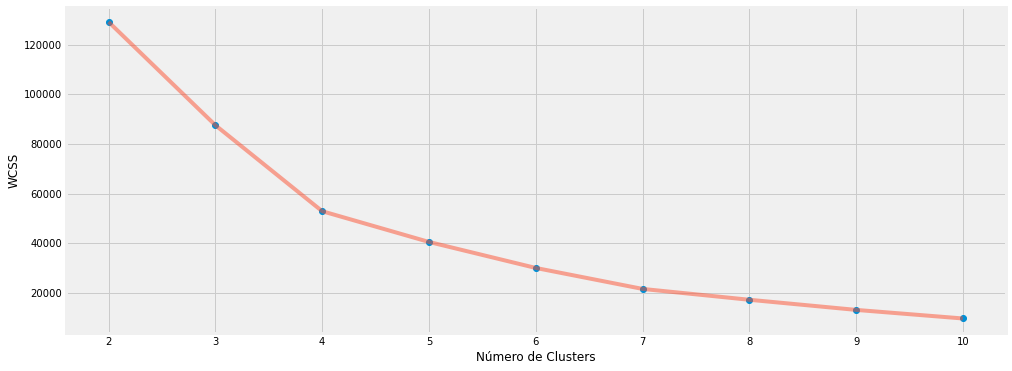

In [32]:
# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , wcss_X1 , 'o')
plt.plot(np.arange(2 , 11) , wcss_X1 , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('WCSS')
plt.show()

Escolhemos o valor ideal de clusters e criamos o modelo final para a Segmentação 1. Observe no gráfico acima que não há certo ou errado. Poderíamos trabalhar com qualquer valor entre 2 e 10 (não faz sentido criar apenas 1 cluster).

O gráfico acima é chamado de Curva de Elbow e normalmente usamos o valor com o menor WCSS. Mas isso deve ser alinhado com as necessidade de negócio. Para esse exemplo, não faria sentido usar 10 clusters. Vamos começar com 2 clusters e avaliar e interpretar os resultados.

#### Segmentação 1 - Construindo e Treinando o Modelo

In [33]:
# Criação do modelo
modelo_seg1 = KMeans(n_clusters = 2, 
                     init = 'k-means++', 
                     n_init = 10, 
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan')

In [34]:
# Treinamento do modelo
modelo_seg1.fit(X1)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [35]:
# Extração dos labels
labels1 = modelo_seg1.labels_
labels1

array([0, 0, 1, ..., 0, 0, 0])

In [36]:
# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

array([[0.881644  , 1.82183485],
       [3.79958153, 4.05580631]])

#### Segmentação 1 - Visualização e Interpretação dos Segmentos

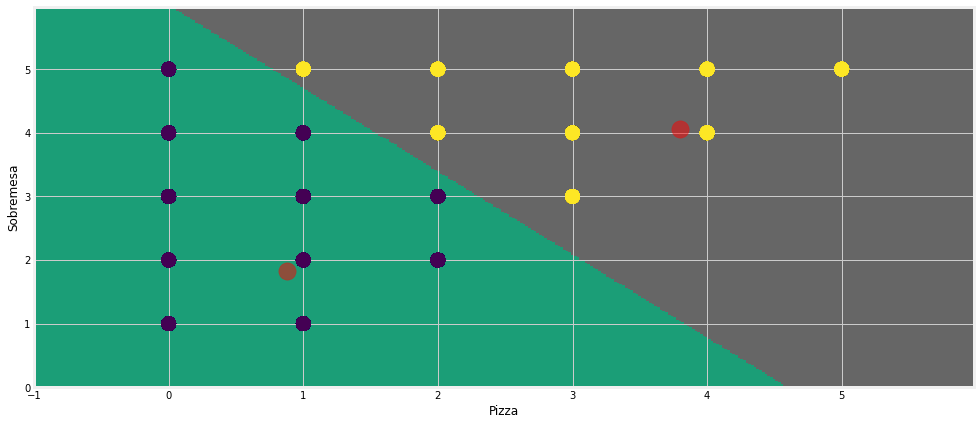

In [62]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Dark2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'sobremesa', data = df, c = labels1, s = 200 )
plt.scatter(x = centroids1[: , 0], y =  centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área em verde) temos os clientes que pediram 0, 1 ou 2 Pizzas. Em todos os casos houve pedido de Sobremesa.


- No cluster 2 (área em cinza) estão clientes que pediram 2, 3, 4 ou 5 Pizzas. Perceba que à medida que o pedido tem maior número de Pizzas, também aumenta o número de Sobremesas.

**Análise**:

- Cluster 1 - Clientes que pedem menos Pizzas. Todos pedem sobremesa.

- Cluster 2 - Clientes que pedem mais Pizzas. Todos pedem sobremesa em volume maior.

Como estratégia de Marketing, poderíamos oferecer ao cliente uma sobremesa grátis no caso de comprar mais uma Pizza de maior valor. Com base na Segmentação provavelmente essa estratégia teria sucesso.

### Segmentação 2

Vamos realizar nossa segunda segmentação usando 2 variáveis.

#### Segmentação 2 - Definindo o Número de Atributos


Usando 2 Variáveis (Pizza e Salada).

In [38]:
# Usaremos duas variáveis
X2 = df[['pizza' , 'salada']].iloc[: , :].values

In [39]:
# Lista do WCSS
wcss_X2 = []

In [40]:
# Loop para testar os valores de K
for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X2)
    wcss_X2.append(modelo.inertia_)

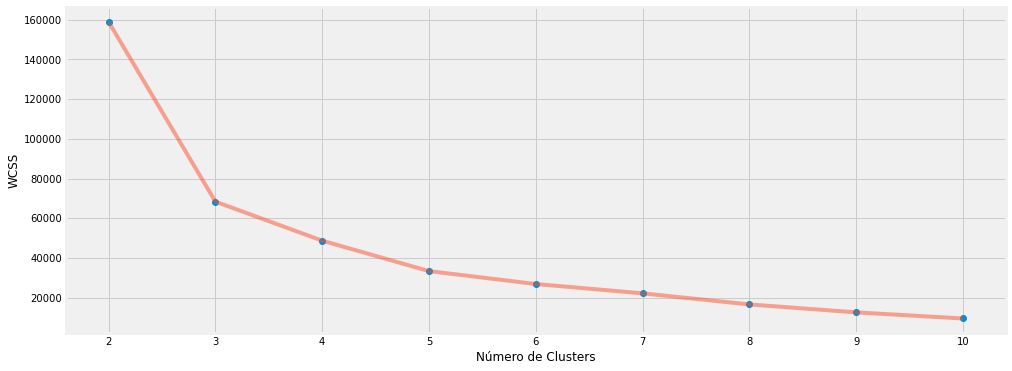

In [41]:
# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , wcss_X2 , 'o')
plt.plot(np.arange(2 , 11) , wcss_X2 , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('WCSS')
plt.show()

In [42]:
# Criação do modelo com 3 clusters
modelo_seg2 = KMeans(n_clusters = 3, 
                     init = 'k-means++', 
                     n_init = 10, 
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan')

In [43]:
# Treinamento do modelo
modelo_seg2.fit(X2)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [44]:
# Extração dos labels
labels2 = modelo_seg2.labels_
labels2

array([2, 2, 1, ..., 2, 2, 2])

In [45]:
# Extração dos centróides
centroids2 = modelo_seg2.cluster_centers_
centroids2

array([[0.20043266, 2.11956596],
       [3.88929248, 0.14175282],
       [1.41384126, 0.12530064]])

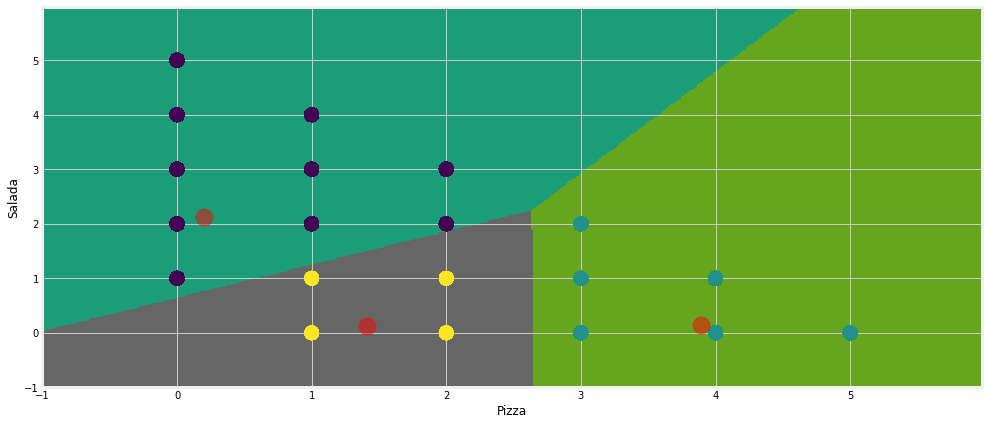

In [61]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
A = modelo_seg2.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
A = A.reshape(xx.shape)

# Plot da imagem
plt.imshow(A, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Dark2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'salada', data = df, c = labels2, s = 200 )
plt.scatter(x = centroids2[: , 0], y =  centroids2[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Salada')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área azul) temos os clientes que pediram menos Pizzas e mais saladas.


- No cluster 2 (área cinza) temos os clientes que pediram poucas Pizzas e poucas Saladas.


- No cluster 3 (área em verde) estão clientes que pediram mais Pizzas e menos Saladas.

**Análise**:

Os clusters 1 e 3 são de clientes com comportamentos opostos. A equipe de Marketing poderia concentrar os esforços nos clientes do cluster 2, pois são clientes que compram Pizzas e Saladas e, portanto, tendem a consumir mais itens variados evitando manter os estoques cheios de um único item. 

Ou então, concentrar os esforços nos clientes que consomem produtos que geram mais lucro. Teríamos que verificar qual item, Pizza ou Salada, é mais rentável.

## Segmentação 3


Usando 2 Variáveis (Pizza e localidade).

In [52]:
# Filtrando o dataframe por colunas 
df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

index  bebida  pizza  sobremesa  salada  localidade
0          0       0      1          1       0           9
1          1       0      2          2       0           6
2          2       4      4          5       1           9
3          3       0      1          1       0           6
4          4       3      3          3       0           2
5          5       3      3          4       1           9
6          6       3      4          4       0           5
7          7       4      4          5       1           4
8          8       4      4          4       0           5
9          9       0      2          2       0           6
10        10       0      0          1       1           4
11        11       0      1          3       2           8
12        12       0      1          1       0           2
13        13       0      1          1       0           2
14        14       3      3          3       0           4
15        15       0      2          2       0           6
16        16       0      0          2       2           9
17        17       0      1          1       0           6
18        18       0      1          1       0           6
19        19       1      2          2       0           6
20        20       3      3          3       0           7
21        21       0      0          5       5           2
22        22       5      5          5       0           7
23        23       5      5          5       0           6
24        24       0      1          1       0           4
25        25       0      1          2       1           9
26        26       0      1          1       0           1
27        27       0      0          2       2           3
28        28       2      2          3       1           7
29        29       0      1          1       0           1
...      ...     ...    ...        ...     ...         ...
99970  99970       0      1          1       0           6
99971  99971       1      1          1       0           3
99972  99972       5      5          5       0           6
99973  99973       0      1          1       0           6
99974  99974       0      0          3       3           1
99975  99975       0      0          2       2           8
99976  99976       1      1          1       0           4
99977  99977       0      3          3       0           6
99978  99978       3      3          4       1           4
99979  99979       0      2          2       0           2
99980  99980       0      1          1       0           2
99981  99981       3      3          3       0           4
99982  99982       0      0          3       3           8
99983  99983       4      4          4       0           8
99984  99984       0      1          1       0           3
99985  99985       3      3          4       1           7
99986  99986       4      4          4       0           7
99987  99987       0      1          1       0           6
99988  99988       0      0          1       1           3
99989  99989       3      3          3       0           7
99990  99990       1      1          2       1           3
99991  99991       5      5          5       0           4
99992  99992       0      2          2       0           9
99993  99993       0      0          1       1           5
99994  99994       1      1          2       1           5
99995  99995       4      4          4       0           4
99996  99996       0      1          1       0           2
99997  99997       1      1          1       0           2
99998  99998       0      2          2       0           3
99999  99999       0      1          1       0           2

[100000 rows x 6 columns]

In [48]:
df2 = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada', 'localidade']]

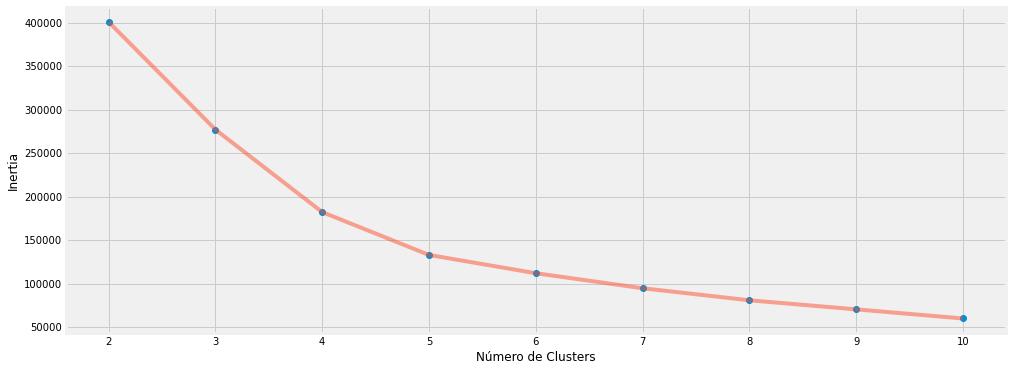

In [49]:
# Usaremos duas variáveis
X3 = df2[['pizza' , 'localidade']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X3)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

In [50]:
# Criação do modelo com 4 clusters
modelo_seg3 = (KMeans(n_clusters = 4,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg3.fit(X3)

# Labels
labels3 = modelo_seg3.labels_

# Centróides
centroids3 = modelo_seg3.cluster_centers_

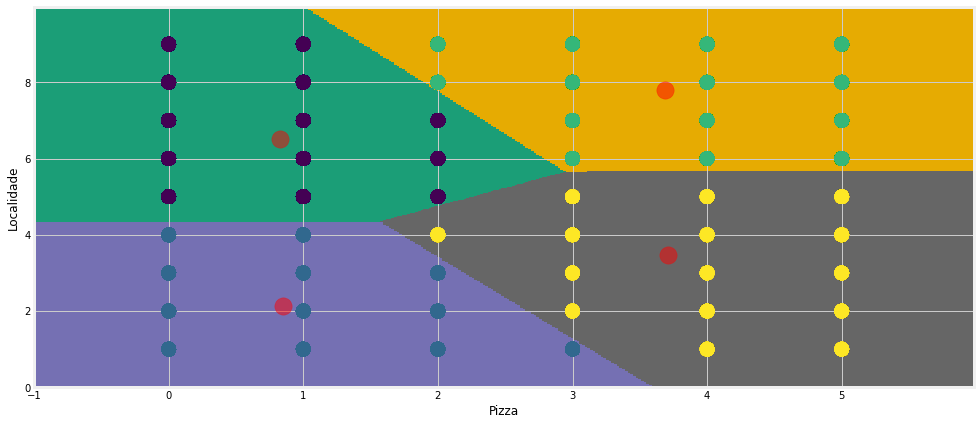

In [63]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
B = modelo_seg3.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
B = B.reshape(xx.shape)

# Plot da imagem
plt.imshow(B, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Dark2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'localidade', data = df2, c = labels3, s = 200 )
plt.scatter(x = centroids3[: , 0], y =  centroids3[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Localidade')
plt.show()

**Interpretação:**

- O ponto vermelho é o centróide de cada cluster (segmento).


- Observe que os clusters da esquerda no gráfico contém os pedidos de todas as Localidades, mas com menor número de Pizzas. Já os clusters da direita no gráfico contém pedidos de todas as Localidades com com maior número de Pizzas.

### Segmentação 4

Segmentação 4 - Variáveis Pizza, Salada e Localidade

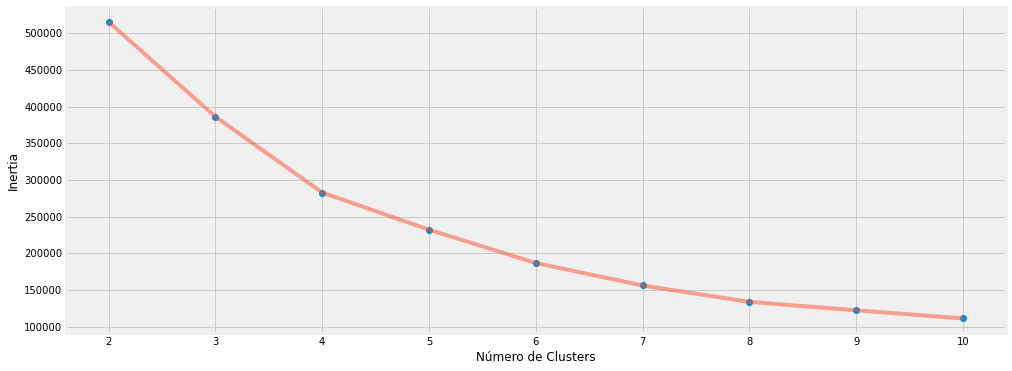

In [54]:
# Usaremos três variáveis
X4 = df2[['pizza' , 'salada' , 'localidade']].iloc[: , :].values

# Lista de valores de Inertia (Inertia e WCSS são a mesma coisa)
inertia = []

# Loop para testar os valores de K
for n in range(2 , 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++', 
                     n_init = 10,
                     max_iter = 300, 
                     tol = 0.0001,  
                     random_state = 111, 
                     algorithm = 'elkan'))
    modelo.fit(X4)
    inertia.append(modelo.inertia_)

# Plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o')
plt.plot(np.arange(2 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Inertia')
plt.show()

In [55]:
# Criação do modelo com 4 clusters
modelo_seg4 = (KMeans(n_clusters = 4,
                      init = 'k-means++', 
                      n_init = 10 ,
                      max_iter = 300, 
                      tol = 0.0001,  
                      random_state = 111  , 
                      algorithm = 'elkan') )

# Treinamento do modelo
modelo_seg4.fit(X4)

# Labels
labels4 = modelo_seg4.labels_

# Centróides
centroids4 = modelo_seg4.cluster_centers_

In [56]:
# Instala o Plotly
!pip install -q plotly

In [57]:
# Pacotes para o gráfico 3D
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

In [64]:
# Plot

# Gráfico 3D
grafico = go.Scatter3d(x = df2['pizza'], 
                       y = df2['salada'], 
                       z = df2['localidade'], 
                       mode = 'markers', 
                       marker = dict(color = labels4, 
                                     size = 4,
                                     line = dict(color = labels4, width = 15),
                                     opacity = 0.7))

# Layout do gráfico
layout = go.Layout(title = 'Clusters',
                   scene = dict(xaxis = dict(title  = 'Pizza'),
                                yaxis = dict(title  = 'Salada'),
                                zaxis = dict(title  = 'Localidade')))

# Plot da figura (gráfico + layout)
fig = go.Figure(data = grafico, layout = layout)
py.offline.iplot(fig)

# Fim 